# KNN 분류 - 피마 인디언 당뇨병 데이터 셋

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
from sklearnex import patch_sklearn
patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from sklearn.svm import LinearSVC, SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB
None

데이터프레임 상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   

## #02. 데이터 전처리

### [1] 이전 예제에서 수립한 전처리 전략 재현

1. `0`값을 포함해서는 안되는 변수에 대해 평균으로 대체

#### (1) 정제 대상 필드명

In [3]:
zero_features = ['Pregnancies','Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']
origin[zero_features]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,6,148,72,35,0,33.6
1,1,85,66,29,0,26.6
2,8,183,64,0,0,23.3
3,1,89,66,23,94,28.1
4,0,137,40,35,168,43.1
...,...,...,...,...,...,...
763,10,101,76,48,180,32.9
764,2,122,70,27,0,36.8
765,5,121,72,23,112,26.2
766,1,126,60,0,0,30.1


#### (2) `0`값을 결측치로 대체후 평균으로 다시 치환

In [4]:
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df1 = my_replace_missing_value(df)

#### (3) 결과 확인

In [5]:
total_count = len(origin)

for feature in zero_features:
    zero_count =origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---"*30)

for feature in zero_features:
    zero_count = df1[df1[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))
    

Pregnancies 0 건수는 111, 퍼센트는 14.45 %
Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Pregnancies 0 건수는 0, 퍼센트는 0.00 %
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


In [6]:
df1 = my_labelling(origin, 'Outcome')

x_train, x_test, y_train, y_test = my_train_test_split(df1, yname='Outcome', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [7]:
estimator = LinearSVC(
    penalty='l2',
    C=1, 
    loss='hinge', 
    max_iter=1000, 
    dual=True,
    random_state=0
)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  0.6986970684039088
검증데이터 점수:  0.6493506493506493


### [2] 성능평가

분류 확률을 얻을 수 없기 때문에 `predict_proba()` 메서드가 제공되지 않는다.

그러므로 `roc_curve` 시각화가 불가능하며 `auc`값을 얻을 수 없다

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.698697 |     0.649351 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.634409 |     0.576923 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.280952 |     0.258621 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0841584 |     0.114583 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.915842 |     0.885417 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.389439 |     0.357143 | 정밀도와 재현율의 조화평균                                |
+-------------------+--------------+--------------+-------------------------------------------------

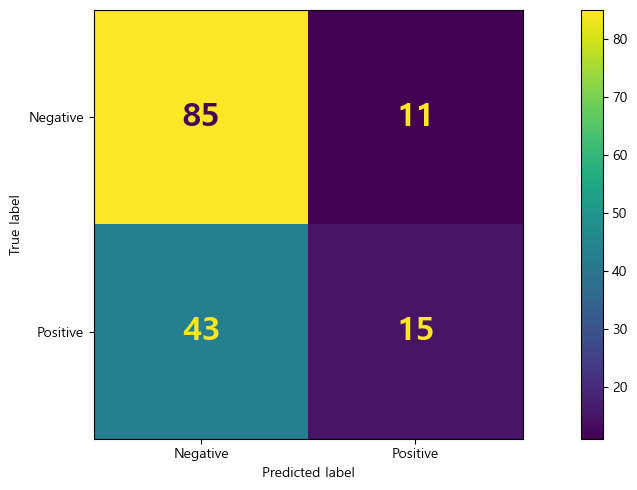


[학습곡선]


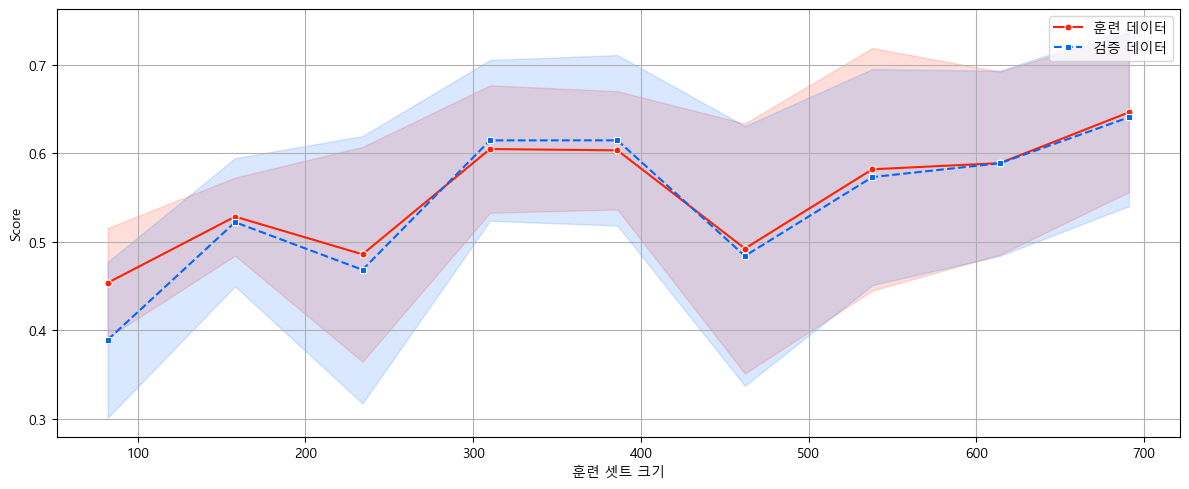

In [8]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

## 03. SVC 

### [1] 분류 모델 구현

In [9]:
estimator = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='scale', 
    coef0=0.0, 
    shrinking=True, 
    probability=True,   # AUC 값 확인을 위해서는 True로 설정 
    max_iter=-1)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  0.7638436482084691
검증데이터 점수:  0.7792207792207793


### [2] 성능평가

분류 확률을 얻을 수 없기 때문에 `predict_proba()` 메서드가 제공되지 않는다.

그러므로 `roc_curve` 시각화가 불가능하며 `auc`값을 얻을 수 없다

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.763844 |     0.779221 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.744361 |     0.833333 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.471429 |     0.517241 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0841584 |       0.0625 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.915842 |       0.9375 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.577259 |     0.638298 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.822065 |      0.85722 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

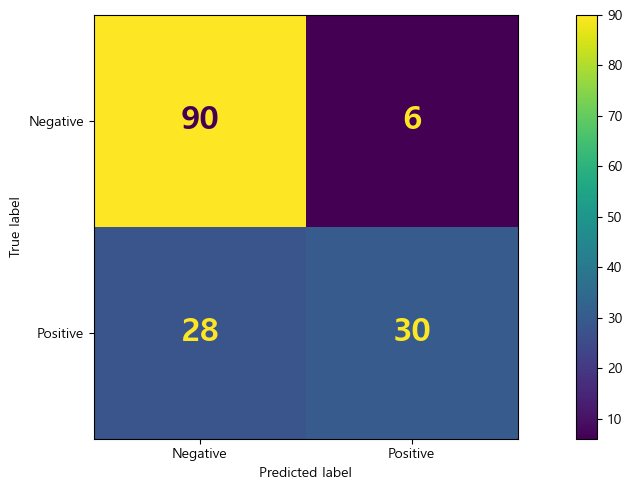

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


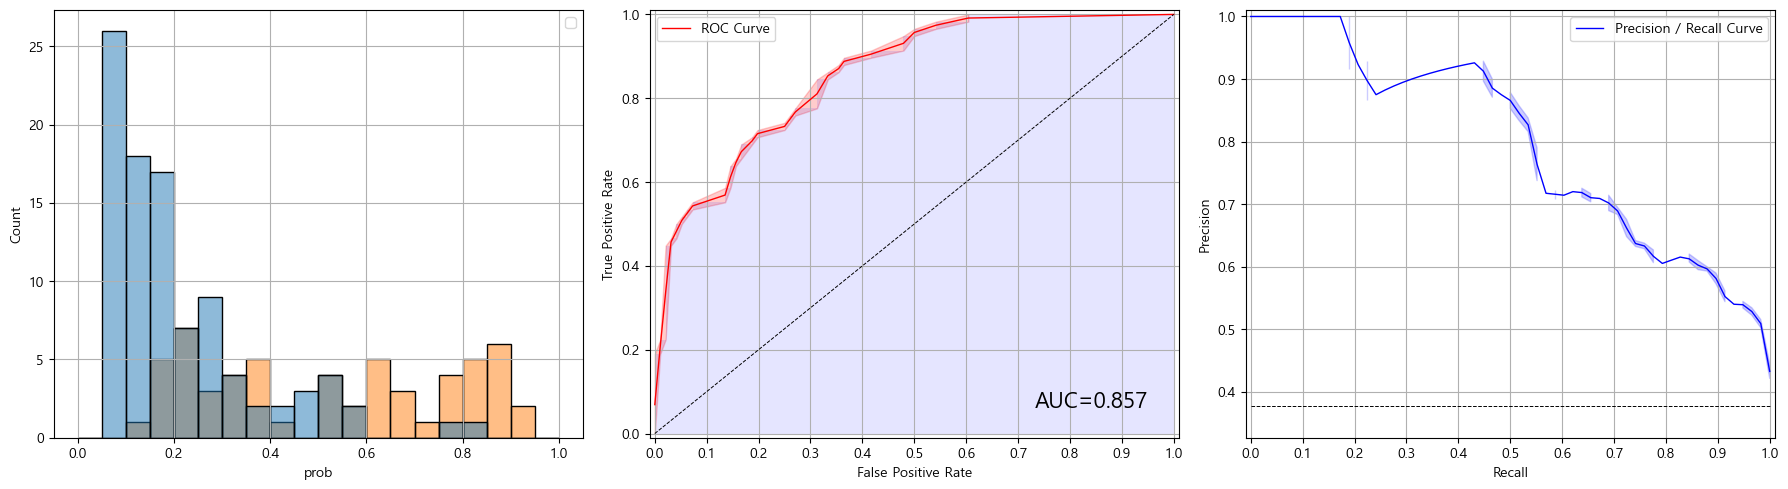


[학습곡선]


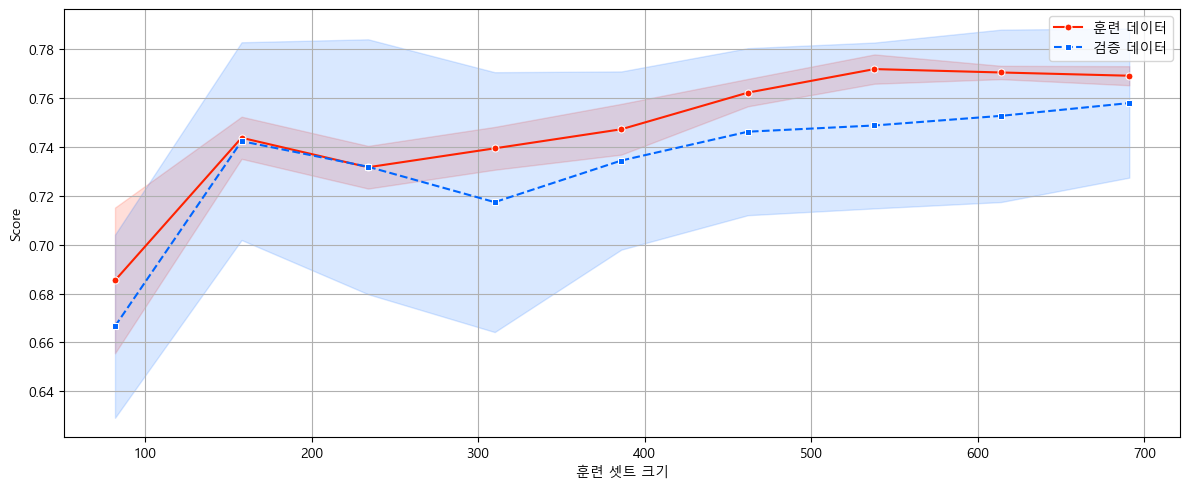

In [10]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [3] 모듈화 기능 확인

n_jobs를 허용하지 않음
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[교차검증 TOP5]
+----+----------------+-----------+------------+---------------+--------+-----+-------------------+
|    |   random_state | penalty   |   max_iter | loss          | dual   |   C |   mean_test_score |
|----+----------------+-----------+------------+---------------+--------+-----+-------------------|
| 20 |           1234 | l1        |       1000 | squared_hinge | False  |   1 |          0.768799 |
| 28 |           1234 | l1        |       1000 | squared_hinge | False  |  10 |          0.768799 |
| 29 |           1234 | l2        |       1000 | squared_hinge | False  |  10 |          0.768799 |
| 21 |           1234 | l2        |       1000 | squared_hinge | False  |   1 |          0.765547 |
| 12 |           1234 | l1        |       1000 | squared_hinge | False  | 0.1 |          0.763934 |
+----+----------------+-----------+------------+---------------+--------+-----+-------------------+

[분류분석 성능평

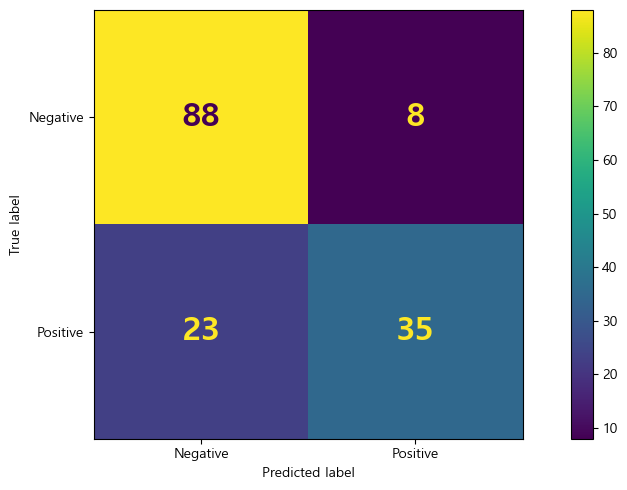


[학습곡선]


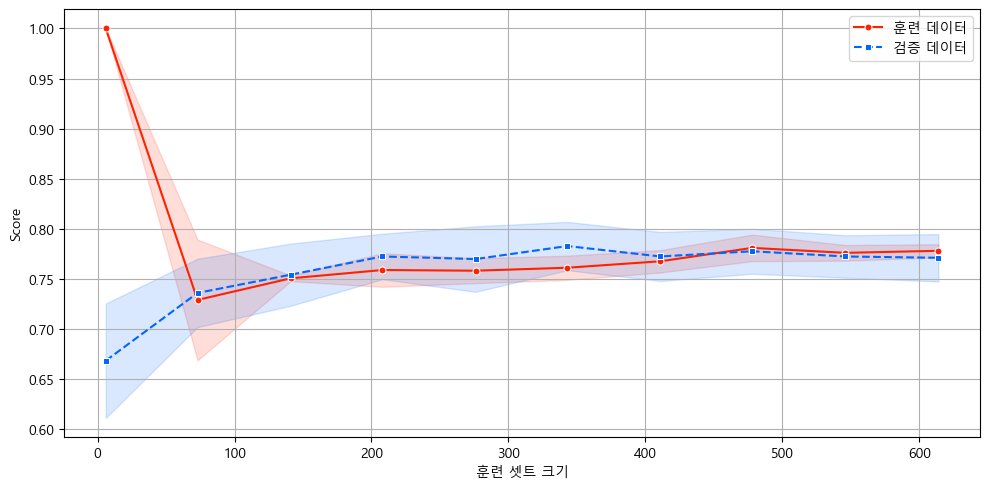

LinearSVC(C=1, dual=False, penalty='l1', random_state=1234)

In [11]:
my_linear_svc_classification(x_train, y_train, x_test, y_test)

### [4] 모든 모형에 대한 성능 비교 모듈 

In [ ]:
my_classification(x_train, y_train, x_test, y_test)

## #02. LinearSVC (Linear Support Vector Machine Classification)

### [1] 분류 모델 구현

In [ ]:
estimator = LinearSVC(
    penalty='l2',
    C=1, 
    loss='hinge', 
    max_iter=1000, 
    dual=True,
    random_state=0
)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

### [2] 성능평가

분류 확률을 얻을 수 없기 때문에 `predict_proba()` 메서드가 제공되지 않는다.

그러므로 `roc_curve` 시각화가 불가능하며 `auc`값을 얻을 수 없다

In [ ]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

## 03. SVC 

### [1] 분류 모델 구현

In [ ]:
estimator = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='scale', 
    coef0=0.0, 
    shrinking=True, 
    probability=True,   # AUC 값 확인을 위해서는 True로 설정 
    max_iter=-1)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

### [2] 성능평가

분류 확률을 얻을 수 없기 때문에 `predict_proba()` 메서드가 제공되지 않는다.

그러므로 `roc_curve` 시각화가 불가능하며 `auc`값을 얻을 수 없다

In [ ]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)